### CNN model of Digit Recognizer using Pytorch

Hoon Kim (id : KeyboardWarrior6969)


**1. Introduction**

**2. Data Preparation**

- 2.1 Load Data
- 2.2 Check for Null and missing Values
- 2.3 Plot Sample Images
- 2.4 Data Label Distribution and Splitting
- 2.5 Training and Validation Data Split
- 2.6 Annealer
- 2.7 Plot transformed images

**3. Cnn Model**
- 3.1 Prepare Data Loader
- 3.2 Model
- 3.3 Optimizer
- 3.4 Model Training

**4. Model Performance**
- 4.1 Training and Validation Curves
- 4.2 Save Model

## 1. Introduction
The aim of this notebook is to build a model, evaluate the model and save it for future use.

In [166]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

np.random.seed(2)
sns.set(style = 'white', context= 'notebook', palette = 'deep')

In [167]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, Compose, ToTensor,CenterCrop, RandomApply, RandomRotation

# for the gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
print(device)

cuda


## 2. Data Preparation

### 2.1 Load Data

In [168]:
# Load the data
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

### 2.2 Check for null and missing values

In [169]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [170]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 Plot Sample Images

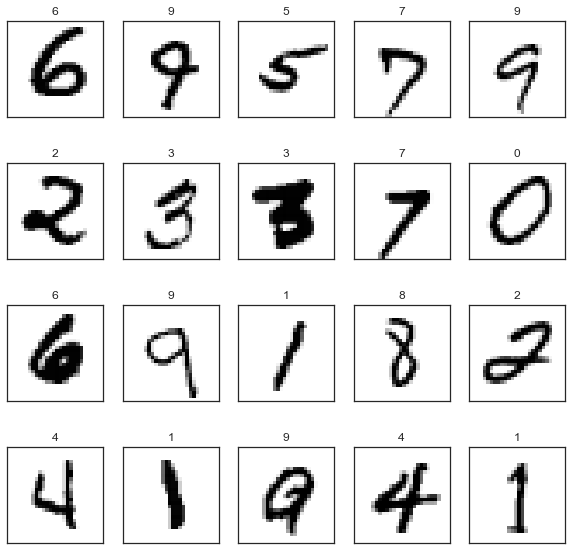

In [171]:
sample = train.sample(n= 20)
sample_y = sample['label'].to_numpy()
sample_x = sample.drop(labels = ['label'], axis = 1) # drop labels
sample_x = sample_x.values.reshape(-1,28,28,1)

j=0
fig=plt.figure(figsize=(10, 10))
while j < 20:

    img = sample_x[j]
    fig.add_subplot(4,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(sample_y[j])
    j += 1
plt.show()

#### 2.4 Data Label Distribution and Splitting

C:\Users\Hoon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

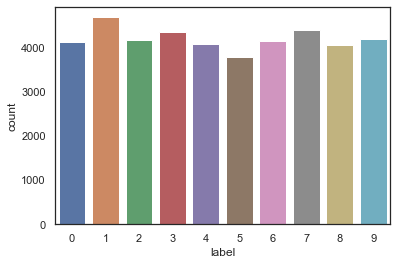

In [172]:
Y_train = train['label'] #extract labels
X_train = train.drop(labels = ['label'], axis = 1).to_numpy() # drop labels
del train # free memory

g = sns.countplot(Y_train)
g

#### 2.5 Training and Validation Data Split


In [173]:
train_idx, val_idx = train_test_split(list(range(len(Y_train))), test_size = 0.2)

x_val = [X_train[k] for k in val_idx]
y_val = [Y_train[k] for k in val_idx]

x_train = [X_train[k] for k in train_idx]
y_train = [Y_train[k] for k in train_idx]

#### 2.6 Annealer


In [174]:
class dataset(Dataset):

        def __init__(self, imgs, labels,transforms):
            self.imgs = imgs
            self.labels = labels
            self.transforms = transforms

        def __len__(self): # Unncessary Method
            self.imgs_length = len(self.imgs)
            return self.imgs_length

        def __getitem__(self,idx):
            im = self.imgs[idx].reshape((28,28))
            x = Image.fromarray(im.astype(np.uint8))
            if self.transforms:
                x = self.transforms(x)
            label = self.labels[idx]
            return x, label

In [175]:
def transformz(x):
    img_transformz = Compose([
        RandomRotation((-15,15),expand = True), # Rotate the image with a random angle between 15
        # degrees clockwise and anti clockwise
        RandomApply([CenterCrop(26)],p = 0.6), # Random apply a Center Crop to Images, probability = 0.6
        Resize(28), # resize images to 32 by 32
        ToTensor() # Normalizes the image and converts the image to a torch.tensor dtype

    ])
    return img_transformz(x)



In [176]:
train_data = dataset(x_train, y_train,transformz)
val_data  = dataset(x_val, y_val,transformz)

#### 2.7 Plot transformed images

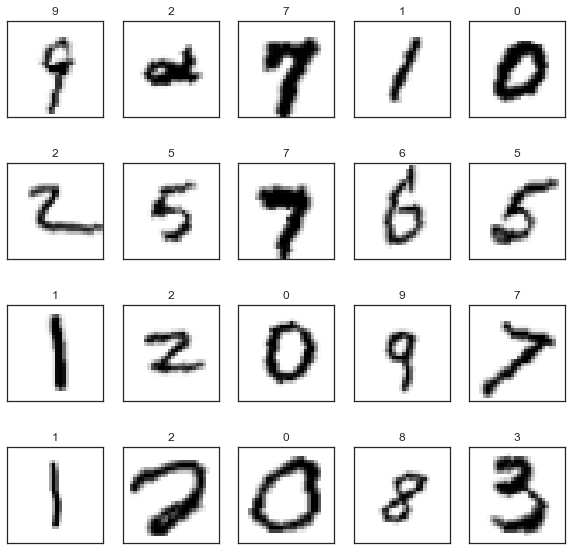

In [177]:
import random
#Generate 20 random numbers between 0 and number of training data samples
randomlist = random.sample(range(0, len(y_train)), 20)

# Check the Images have been rotated to some degree
fig=plt.figure(figsize=(10, 10))
k = 0
for j in randomlist:

    fig.add_subplot(4,5,k+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(train_data[j][0]), cmap=plt.cm.binary)
    plt.title(train_data[j][1])
    k += 1
plt.show()

### CNN Model

#### 3.1 Prepare Data Loaders

In [178]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
val_loader = DataLoader(dataset = val_data, batch_size=16, shuffle=True )

#### 3.2 Model

In [179]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )


        self.fc1 = nn.Linear(5*5*64,32)
        self.dropout = nn.Dropout(0.8)
        self.fc2 = nn.Linear(32,10)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

#### 3.3 Optimizer

In [180]:
# Initialize model
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

#### 3.4 Model Training

In [181]:
history = {'training_acc' : [],'val_loss' : [],'val_acc' : [],'train_loss' : []}
def train(epoch):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
    history['training_acc'].append(epoch_accuracy)
    history['val_acc'].append(epoch_val_accuracy)
    history['train_loss'].append(epoch_loss)
    history['val_loss'].append(epoch_val_loss)

In [ ]:
for epoch in range(0, 10):
    train(epoch)

Epoch : 1, train accuracy : 0.9372037053108215, train loss : 0.2058538943529129
Epoch : 1, val_accuracy : 0.9658352732658386, val_loss : 0.10863969475030899
Epoch : 2, train accuracy : 0.9692542552947998, train loss : 0.09732561558485031
Epoch : 2, val_accuracy : 0.9750024676322937, val_loss : 0.08555920422077179
Epoch : 3, train accuracy : 0.9741346836090088, train loss : 0.07985600084066391
Epoch : 3, val_accuracy : 0.9738117456436157, val_loss : 0.08326078951358795
Epoch : 4, train accuracy : 0.9757407307624817, train loss : 0.07485494017601013
Epoch : 4, val_accuracy : 0.97464519739151, val_loss : 0.0825965404510498
Epoch : 5, train accuracy : 0.9777643084526062, train loss : 0.06903212517499924
Epoch : 5, val_accuracy : 0.9736925959587097, val_loss : 0.08432139456272125
Epoch : 6, train accuracy : 0.9778534770011902, train loss : 0.06763683259487152
Epoch : 6, val_accuracy : 0.9811932444572449, val_loss : 0.06856739521026611


### 4. Model Performance

#### 4.1 Training and Validation Curves

In [ ]:
df = pd.DataFrame.from_dict(history, orient='columns')
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(df.train_loss, color='b', label="Training loss")
ax[0].plot(df.val_loss, color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(df.training_acc, color='b', label="Training accuracy")
ax[1].plot(df.val_acc, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#### 4.2 Save Model

In [ ]:
# Specify a path
PATH = "HooNN.pt"

# Save
torch.save(model.state_dict(), PATH)
